# Machine Learning and NLP Exercises #

## Introduction ##

We will be using the same review data set from Kaggle from Week 2 for this exercise. The product we'll focus on this time is a cappuccino cup. The goal of this week is to not only preprocess the data, but to classify reviews as positive or negative based on the review text.

The following code will help you load in the data.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nltk
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('../data/coffee.csv')
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


## Question 1 ##

* Determine how many reviews there are in total.
* Determine the percent of 1, 2, 3, 4 and 5 star reviews.
* Create a new data set for modeling with the following columns:
     - Column 1: 'positive' if review = 4 or 5, and 'negative' if review = 1 or 2
     - Column 2: review text
* Take a look at the number of positive and negative reviews in the newly created data set.

Checkpoint: the resulting data set should have 514 reviews.

Use the preprocessing code below to clean the reviews data before moving on to modeling.

In [4]:
print('The number of reviews is',data.shape[0])

The number of reviews is 542


In [5]:
(data.groupby('stars').size())

stars
1     96
2     45
3     28
4     65
5    308
dtype: int64

In [6]:
stopwords_english = set(stopwords.words('english'))
data.loc[:,"reviews"] = data.reviews.apply(lambda x:" ".join(re.findall('[\w]+',x)))
def remove_stopwords(s):
    s = " ".join(word for word in s.split() if word not in stopwords_english)
    return s
data.loc[:,"reviews"] = data.reviews.apply(lambda x:remove_stopwords(x))
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted love I even prepared somewhat like ch...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups excellent Tasted ...
2,AJ3L5J7GN09SV,2,I bought Grove Square hazelnut cappuccino k cu...
3,A3CZD34ZTUJME7,1,I love Keurig I love Keurig coffees This insta...
4,AWKN396SHAQGP,1,It powdered drink No filter k cup br Just buy ...


In [7]:
for i in range(data.shape[0]):
    if data.loc[i,'stars']==1 or data.loc[i,'stars']==2:
        data.loc[i,'reviews_text'] = 'negative'
    elif data.loc[i,'stars']==4 or data.loc[i,'stars']==5:
        data.loc[i,'reviews_text'] = 'positive'
data_trim = data[data.reviews_text.apply(lambda x:x=='positive' or x=='negative')]
data_trim.shape

(514, 4)

In [8]:
data_trim.head()

,user_id,stars,reviews,reviews_text
0,A2XP9IN4JOMROD,1,I wanted love I even prepared somewhat like ch...,negative
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups excellent Tasted ...,positive
2,AJ3L5J7GN09SV,2,I bought Grove Square hazelnut cappuccino k cu...,negative
3,A3CZD34ZTUJME7,1,I love Keurig I love Keurig coffees This insta...,negative
4,AWKN396SHAQGP,1,It powdered drink No filter k cup br Just buy ...,negative


In [9]:
data_trim.groupby('reviews_text').size()

reviews_text
negative    141
positive    373
dtype: int64

## Question 2 ##

Prepare the data for modeling:
* Split the data into training and test sets. You should have four sets of data - X_train, X_test, y_train, y_test

Create numerical features with Count Vectorizer. Create two document-term matrices:
* Matrix 1: Terms should be unigrams (single words), and values should be word counts (Hint: this is the Count Vectorizer default)
* Matrix 2: Terms should be unigrams and bigrams, and values should be binary values

Recommendation: Utilize Count Vectorizer's stop words function to remove stop words from the reviews text.

In [10]:
x = data_trim.loc[:,'reviews']
y = data_trim.loc[:,'reviews_text']

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [12]:
cv = CountVectorizer()
xtrain_cv = cv.fit_transform(xtrain).toarray()
xtest_cv = cv.transform(xtest).toarray()

In [13]:
ytest.unique()

array(['negative', 'positive'], dtype=object)

In [14]:
# print(len(y_pred))
# print(y_pred)
count_pos=0;count_neg=0
for i in ytest:
    if i=='positive':
        count_pos+=1
    else:
        count_neg+=1
print(count_pos)
print(count_neg)

70
33


## Question 3 ##

Use Logistic Regression to classify reviews as positive or negative. Do this for both matrices.
* Fit a Logistic Regression model on the training data
* Apply the model on the test data and calculate the following error metrics: accuracy, precision, recall, F1 score
* Optional: Visualize the confusion matrix for both models
* Compare the error metrics of the two matrices

Recommendation: Create a function to calculate the error metrics, since you'll be doing this multiple times.

## Logistic Regression:-Count Vectorizer

In [15]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(xtrain_cv,ytrain)
y_pred = lr.predict(xtest_cv)

In [16]:
def print_confusion_matrix(ytest,y_pred):
    cm = confusion_matrix(ytest, y_pred)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'],
    annot=True, fmt='d', annot_kws={'fontsize':20}, cmap='YlGnBu');
    return cm

def print_accuracy(cm):
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 Score: {}'.format(f1))

Accuracy: 0.806
Precision: 0.805
Recall: 0.943
F1 Score: 0.869


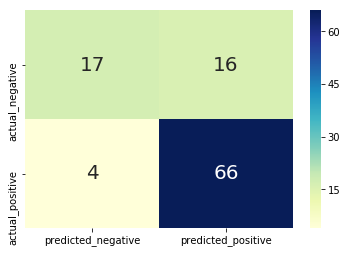

In [17]:
cm = print_confusion_matrix(ytest,y_pred)
print_accuracy(cm)

## Naive Bayes:-Count Vectorizer

In [18]:
nb = MultinomialNB()
nb.fit(xtrain_cv,ytrain)
y_pred = nb.predict(xtest_cv)

Accuracy: 0.854
Precision: 0.848
Recall: 0.957
F1 Score: 0.899


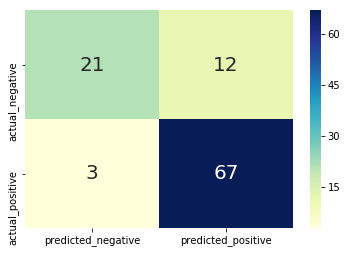

In [19]:
cm = print_confusion_matrix(ytest,y_pred)
print_accuracy(cm)

## Ngrams

In [20]:
def build_ngrams(text,n=2):
    tokens = text.lower().split()
    return list(ngrams(tokens,n))

In [21]:
# def remove_list(features_string):
#     to_string = lambda x:str(x)
#     for i in range(len(features_string)):
#         features_string[i]=to_string(features_string[i])
#     return features_string
def remove_prepare(lis):
    res = [' '.join(i) for i in lis]
    res_str = ' '.join(res)
    return res_str
# print(res)

In [22]:
data_trim.head()

,user_id,stars,reviews,reviews_text
0,A2XP9IN4JOMROD,1,I wanted love I even prepared somewhat like ch...,negative
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups excellent Tasted ...,positive
2,AJ3L5J7GN09SV,2,I bought Grove Square hazelnut cappuccino k cu...,negative
3,A3CZD34ZTUJME7,1,I love Keurig I love Keurig coffees This insta...,negative
4,AWKN396SHAQGP,1,It powdered drink No filter k cup br Just buy ...,negative


In [23]:
# data_trim['unigram_bigram'] = data.reviews.apply(lambda x:' '.join(remove_list(build_ngrams(x,1)+build_ngrams(x,2))))

In [24]:
data_trim['unigram_bigram'] = data.reviews.apply(lambda x:remove_prepare(build_ngrams(x,2)))

C:\Users\abhinav.jha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
data_trim.head()

,user_id,stars,reviews,reviews_text,unigram_bigram
0,A2XP9IN4JOMROD,1,I wanted love I even prepared somewhat like ch...,negative,i wanted wanted love love i i even even prepar...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups excellent Tasted ...,positive,grove square square cappuccino cappuccino cups...
2,AJ3L5J7GN09SV,2,I bought Grove Square hazelnut cappuccino k cu...,negative,i bought bought grove grove square square haze...
3,A3CZD34ZTUJME7,1,I love Keurig I love Keurig coffees This insta...,negative,i love love keurig keurig i i love love keurig...
4,AWKN396SHAQGP,1,It powdered drink No filter k cup br Just buy ...,negative,it powdered powdered drink drink no no filter ...


In [26]:
x = data_trim.loc[:,'unigram_bigram']
y = data_trim.loc[:,'reviews_text']

In [27]:
data_trim.loc[0,'unigram_bigram']

'i wanted wanted love love i i even even prepared prepared somewhat somewhat like like cheap cheap circle circle k k cappuccino cappuccino unfortunately unfortunately product product really really greasy greasy you you actually actually see see grease grease cup cup it it 80 80 calories calories per per serving serving taste taste really really really really powder powder tasting tasting like like powdered powdered milk milk i i expecting expecting starbucks starbucks cap cap k k cup cup i i expecting expecting little little br br br br i i read read reviews reviews sort sort mixed mixed i i chose chose try try i i buy buy they they sit sit top top cupboard cupboard shelf shelf till till desperate desperate i i guess guess throw throw away away three three boxes boxes eesssh eesssh br br br br i i also also realize realize eligible eligible return return sucks sucks oh oh well well buyer buyer beware beware right'

In [28]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

## Question 4 ##

## Unigram+bigram:-TF iDf vectorizer

Let's try using another machine learning technique to classify these reviews as positive or negative. Go through the exact same exercise in the previous step, except this time, use Naive Bayes instead of Logistic Regression.

For count data, use [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). For binary data, use [Bernoulli Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB).

Compare the results of both the Logistic Regression and Naive Bayes models.

## Question 5 ##

Up to this point, we've been using Count Vectorizer to create document-term matrices to input into the models. For at least one of the four models you've created so far, use TF-IDF Vectorizer instead of Count Vectorizer, and see if it improves the results.

Out of all of the models you've created, which model do you think best classifies positive and negative cappuccino cup reviews?

In [29]:
cv = TfidfVectorizer()
xtrain_cv = cv.fit_transform(xtrain).toarray()
xtest_cv = cv.transform(xtest).toarray()

In [30]:
print(len(xtrain_cv[0]))

1990


## Logistic Regression

In [31]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(xtrain_cv,ytrain)
y_pred = lr.predict(xtest_cv)

Accuracy: 0.757
Precision: 0.747
Recall: 1.0
F1 Score: 0.855


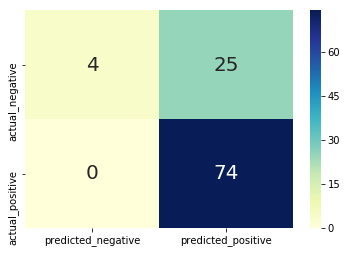

In [32]:
cm = print_confusion_matrix(ytest,y_pred)
print_accuracy(cm)

## Naive Bayes

In [33]:
nb = BernoulliNB()
nb.fit(xtrain_cv,ytrain)
y_pred = nb.predict(xtest_cv)

Accuracy: 0.796
Precision: 0.779
Recall: 1.0
F1 Score: 0.876


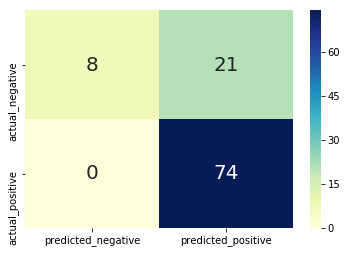

In [34]:
cm = print_confusion_matrix(ytest,y_pred)
print_accuracy(cm)